importing the modules required for neural network

In [547]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

importing the dataset

In [548]:
df = pd.read_csv("ercot-dataset.csv", sep=',')
# to change the float to two decimal places following code is used
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df = df.iloc[:80000]
print(df)

                   Date  DryBulb  DewPnt  WetBulb  Humidity  ElecPrice  Day  \
0         1/1/2006 0:30    23.90   21.65    22.40     87.50      19.67    1   
1         1/1/2006 1:00    23.90   21.70    22.40     88.00      18.56    1   
2         1/1/2006 1:30    23.80   21.65    22.35     88.00      19.09    1   
3         1/1/2006 2:00    23.70   21.60    22.30     88.00      17.40    1   
4         1/1/2006 2:30    23.70   21.60    22.30     88.00      17.00    1   
...                 ...      ...     ...      ...       ...        ...  ...   
87643  31/12/2010 22:00    22.60   19.10    20.40     81.00      23.86   31   
87644  31/12/2010 22:30    22.45   19.05    20.30     81.50      26.49   31   
87645  31/12/2010 23:00    22.30   19.00    20.20     82.00      25.18   31   
87646  31/12/2010 23:30    22.05   19.05    20.15     83.50      26.19   31   
87647     1/1/2011 0:00    21.80   19.10    20.10     85.00      24.62    1   

       Month  Year  Minutes  SYSLoad  
0          1

In [549]:
# prints the high level information about the data
'''df.info()'''

'df.info()'

In [550]:
# gives additional statistical information
'''df.describe()'''

'df.describe()'

In [551]:
# to check the total missing data on each features
# zero indicates there is no missing data values
df.isnull().sum()
#df1 = df.drop(['Date','Month','Year', 'Day','Minutes'], axis=1)
df1 = df.drop(['Date','Year'], axis=1)

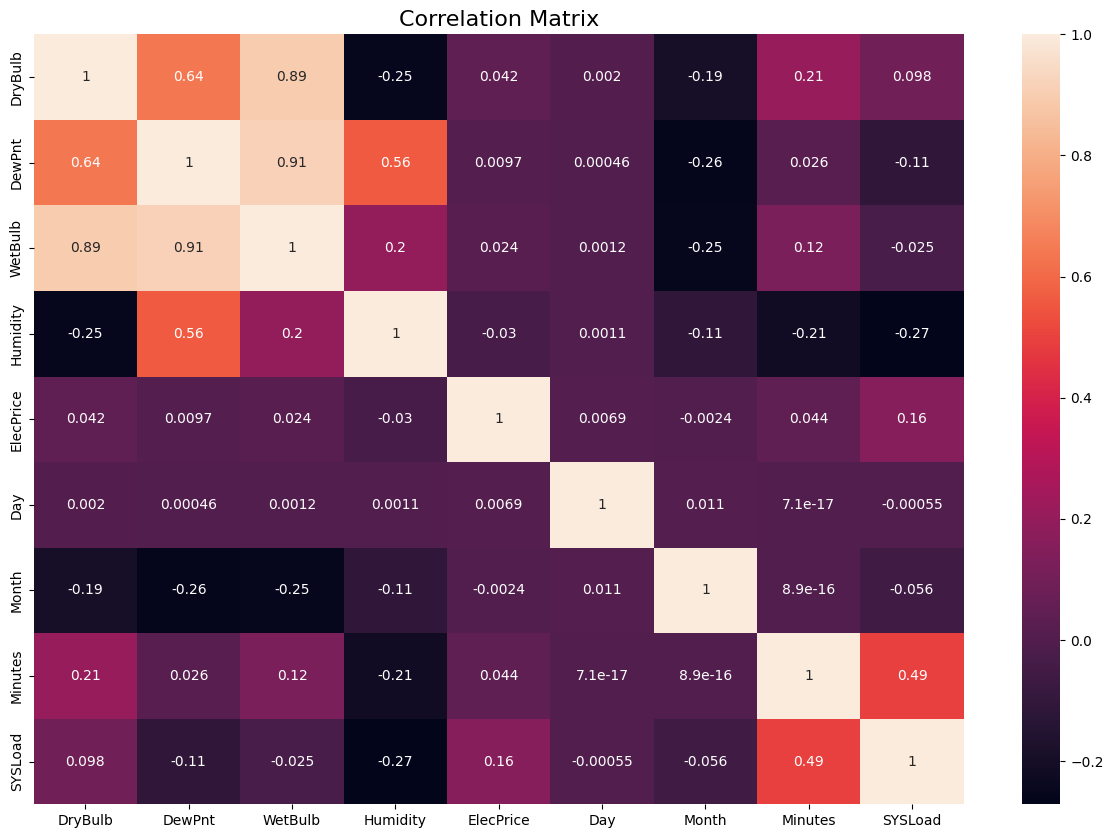

In [552]:
df1.corr()
# to see the correlation between features
# this helps to see how one parameters has effects on others
# lets see the plot of correlation data
sns.heatmap(df1.corr(), annot= True)
plt.rcParams["figure.figsize"]=(15,10)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [553]:
# this will select all the rows and columns except the last one from df and assign to x variable
# df1 does not contain the date in the first column in string format
x = df1.iloc[:,:-1].values
#x = df1.iloc[:,1].values
# quality is taken target variable and it in last column and is assigned to y variable
y = df1.iloc[:,-1].values
# encoding the categorical data using onehotencoder
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [3])], remainder = 'passthrough')
x = ct.fit_transform(x)
x = x.toarray() # converts encoded data to dense array (optional) would show error without this

Splitting the dataset into the training and test set

In [554]:
from sklearn.model_selection import train_test_split
# we will split the data into training and testing data using following code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

feature standardization and conversion to tensor

In [555]:
# Feature Scaling (not necessary for neural networks, but can be applied)
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

# Create a PyTorch dataset and DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
len(train_loader)
#len(test_loader)

1096

Neural Network Model, forward pass and back propagation

Epoch 1/100, Train Loss: 24008412.98745438, Val Loss: 7670912.471259124
Epoch 2/100, Train Loss: 7569708.486656022, Val Loss: 6771051.486770073
Epoch 3/100, Train Loss: 6989331.568202555, Val Loss: 6446642.5843978105
Epoch 4/100, Train Loss: 6707750.000570255, Val Loss: 6234876.625456205
Epoch 5/100, Train Loss: 6455084.85526916, Val Loss: 5977849.0625
Epoch 6/100, Train Loss: 6159378.913663321, Val Loss: 5629839.18339416
Epoch 7/100, Train Loss: 5775019.7973882295, Val Loss: 5185049.1947992705
Epoch 8/100, Train Loss: 5245851.755474453, Val Loss: 4617777.333485401
Epoch 9/100, Train Loss: 4744174.277087135, Val Loss: 4245083.894388686
Epoch 10/100, Train Loss: 4395176.034215328, Val Loss: 3966587.2623175182
Epoch 11/100, Train Loss: 4035265.9871122264, Val Loss: 3502974.9963503648
Epoch 12/100, Train Loss: 2881220.6827668794, Val Loss: 2126676.192518248
Epoch 13/100, Train Loss: 1952115.4764484488, Val Loss: 1755325.031478102
Epoch 14/100, Train Loss: 1685080.5074703468, Val Loss: 157

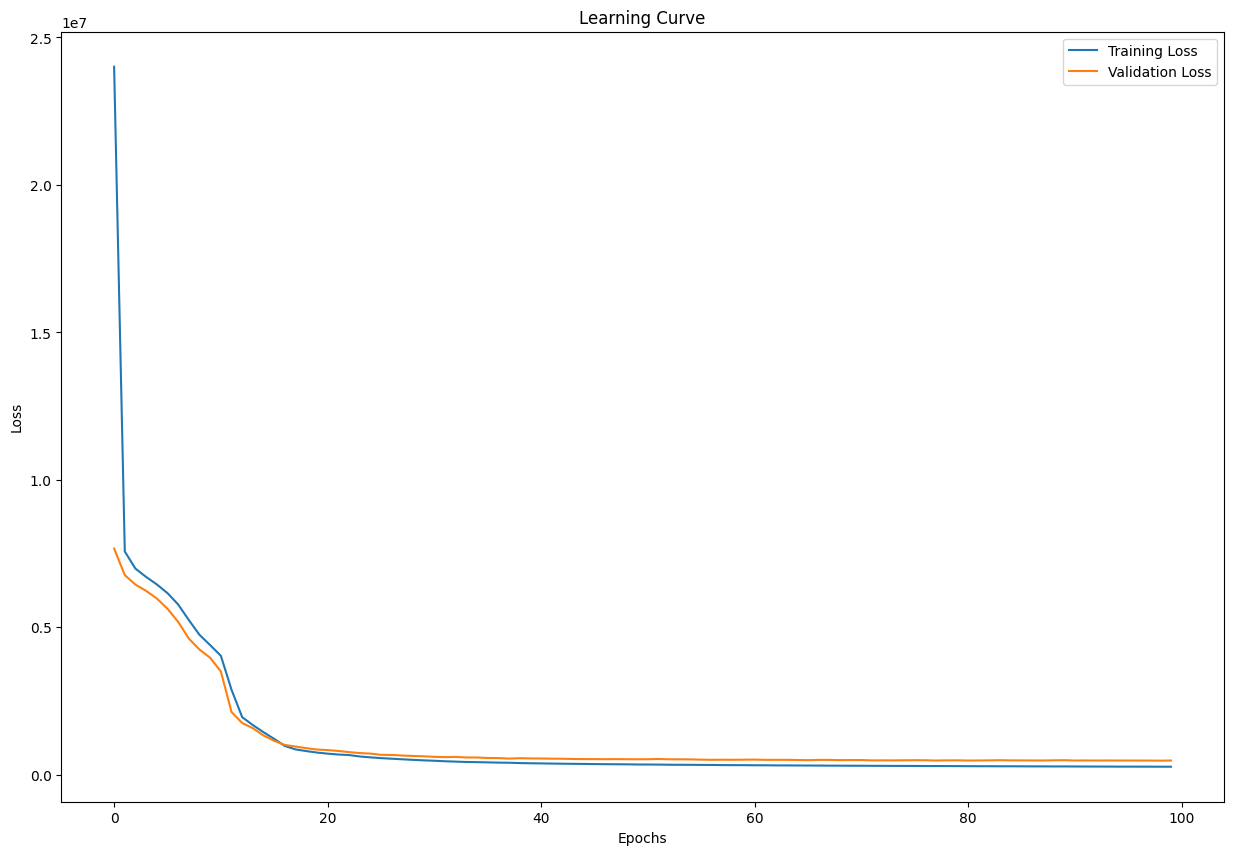

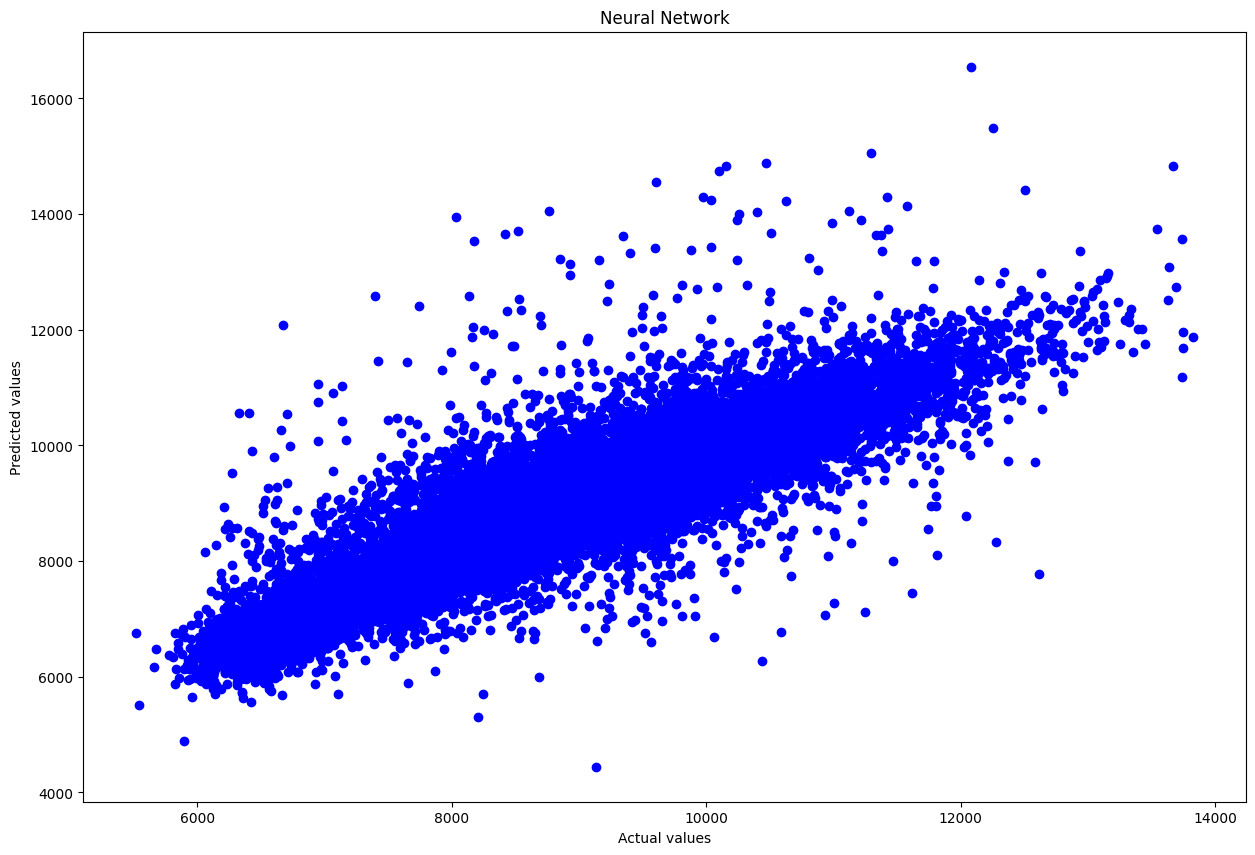

In [556]:
# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)   # using linear activation function at the input
        self.relu = nn.ReLU()   # activation function for hidden layer, sigmoid
        self.fc2 = nn.Linear(128, 64)   # input layer to hidden layer
        self.fc3 = nn.Linear(64, 1) # hidden to output layer

    def forward(self, X):
        X = self.fc1(X)
        X = self.relu(X)
        X = self.fc2(X)
        X = self.relu(X)
        X = self.fc3(X)
        return X
    
# Instantiate the model and define the loss function and optimizer
input_size = x_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)

# Convert predictions back to NumPy arrays
y_pred = y_pred_tensor.numpy()
y_test_np = y_test_tensor.numpy()

# Evaluate the Model Performance
mse = mean_squared_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plotting the results (optional)
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

visualization of the neural network results graphically

In [557]:
print(len(y_pred))
print(len(y_test))
y_pred

17530
17530


array([[ 8828.975],
       [ 9361.751],
       [ 8428.931],
       ...,
       [ 6530.689],
       [ 8496.797],
       [10204.578]], dtype=float32)

In [558]:
y_test

array([8318.64   , 9250.62667, 8168.76   , ..., 6196.25   , 7912.55   ,
       9395.46   ])

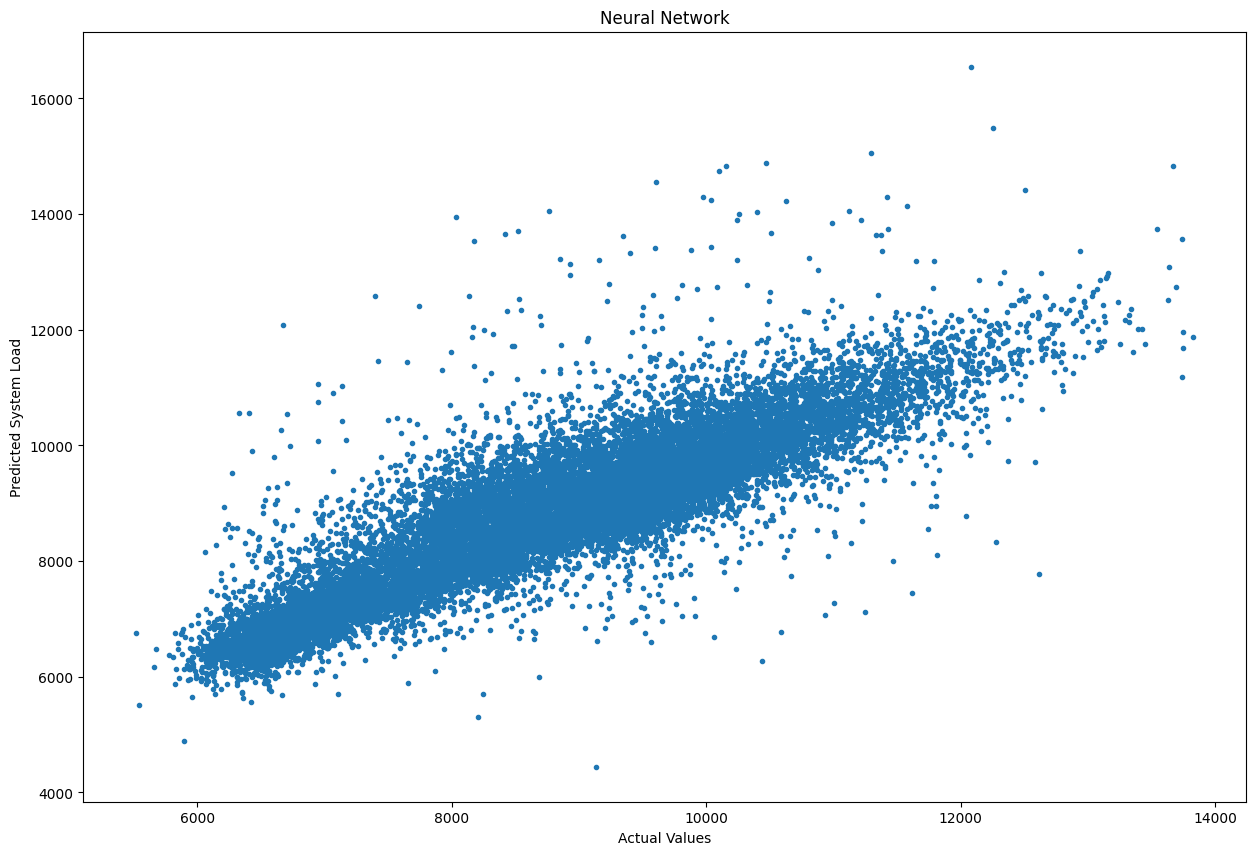

In [559]:
plt.plot(y_test,y_pred, '.')
#plt.plot(x_grid, regressor.predict(x_grid.reshape(-1,1)), color = 'blue')
plt.title('Neural Network')
plt.xlabel('Actual Values')
plt.ylabel('Predicted System Load')
plt.show()

Evaluating the model performance

In [560]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7595970362203599